<a href="https://colab.research.google.com/github/TheGreymanShow/pytorch-cnn-visualize-layers/blob/master/cnn_visualize_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

2. Define CNN Architechture

In [ ]:
class CNN(nn.Module):
    """
    CNN Class that defines the CNN Model
    """

    def __init__(self):
        """CNN Builder."""
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        """Perform forward."""

        # conv layers
        x = self.conv_layer(x)

        # flatten
        x = x.view(x.size(0), -1)

        # fc layer
        x = self.fc_layer(x)

        return x

3. Load data into train and test

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


4. Load the model, loss function and optimizer

In [ ]:
# Define CNN model
net = CNN()
net = net.cuda()
#net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
torch.backends.cudnn.benchmark = True

# Define the Loss Function
criterion = nn.CrossEntropyLoss()

# Define the Optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

 5. Train the model

In [ ]:
train_loss = []
test_loss = []

train_acc = []
test_acc = []

print("Starting Training...\n")
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    train_correct = 0
    train_total =0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.cuda()
        labels = labels.cuda()

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        net.train()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # accumulate the training loss
        running_loss += loss.item()

        # accumulate the training acc score
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_acc.append(100 * train_correct/train_total)
    train_loss.append(running_loss / len(trainloader))
    print(f"Epoch : {epoch} ---- Accuracy : {100 * train_correct/train_total} ---- Loss : {running_loss / len(trainloader)}")


print('Finished Training')

Starting Training...

Epoch : 0 ---- Accuracy : 42.34 ---- Loss : 1.564879679786648
Epoch : 1 ---- Accuracy : 64.954 ---- Loss : 0.9800962931974073
Epoch : 2 ---- Accuracy : 73.348 ---- Loss : 0.7523598462171609
Epoch : 3 ---- Accuracy : 77.854 ---- Loss : 0.6310013564385746
Epoch : 4 ---- Accuracy : 81.564 ---- Loss : 0.5320507804228568
Epoch : 5 ---- Accuracy : 84.162 ---- Loss : 0.4573013869829843
Epoch : 6 ---- Accuracy : 86.524 ---- Loss : 0.39333074524645917
Epoch : 7 ---- Accuracy : 88.586 ---- Loss : 0.3297274539858503
Epoch : 8 ---- Accuracy : 90.522 ---- Loss : 0.27396205674930785
Epoch : 9 ---- Accuracy : 92.192 ---- Loss : 0.22539355157280455
Finished Training


6. Save the trained model

In [ ]:
print('==> Saving model ...')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

==> Saving model ...


7. Load the saved model

In [ ]:
net = CNN()
net = net.cuda()
#net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
torch.backends.cudnn.benchmark = True

PATH = './cifar_net.pth'
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

8. Evaluate Model accuracy

In [ ]:
y_pred = []
y_true = []

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:

        images, labels = data

        images = images.cuda()
        labels = labels.cuda()

        inputs, labels = Variable(inputs), Variable(labels)

        net.eval()

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_pred.extend(predicted)
        y_true.extend(labels)

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 82 %


9. Visualize the learned filter maps

In [ ]:
#structure of the my neural network
print(net)

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [ ]:
import matplotlib.pyplot as plt

def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img


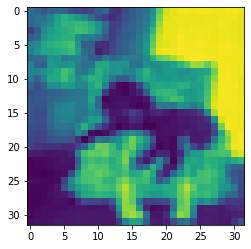

In [ ]:
# Plot some images
idx = torch.randint(0, outputs.size(0), ())
img = inputs[idx, 0]

fig, axarr = plt.subplots(1, 1)
axarr.imshow(img.detach().cpu().numpy())



In [ ]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

net.conv_layer[6].register_forward_hook(get_activation('conv4'))


torch.Size([32, 32])
tensor(0.0786)


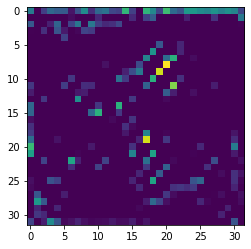

In [ ]:
img_idx = 45


data, _ = trainset[img_idx]
data.unsqueeze_(0)
data = data.cuda()
net.eval()

output = net(data)

act = activation['conv4'].cpu().squeeze()
print(act[25].shape)
fig, axarr = plt.subplots(1,1)
print(act[45].mean())
axarr.imshow(act[45])

In [ ]:
act_means = []

for img_idx in range(10000):
  data, _ = trainset[img_idx]
  data.unsqueeze_(0)
  data = data.cuda()
  output = net(data)
  act = activation['conv4'].cpu().squeeze()
  print(act.shape)
  act_means.append(act[0].mean())

Streaming output truncated to the last 5000 lines.
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([128, 16, 16])
torch.Size([1

In [ ]:
sorted_acc_means = np.argsort(act_means)[::-1]
sorted_acc_means[:3]

array([4057, 7952, 1215])

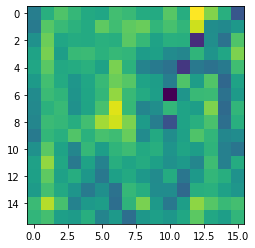

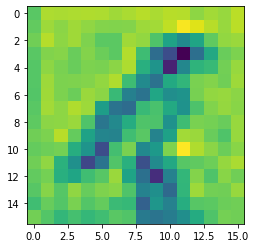

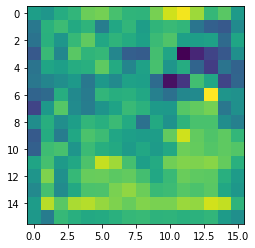

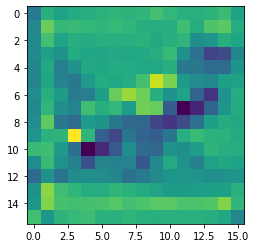

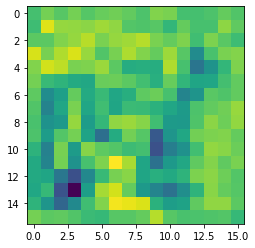

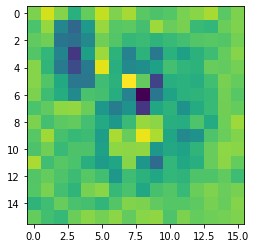

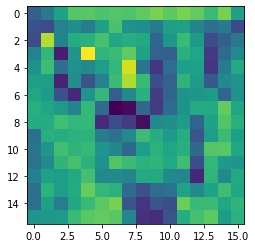

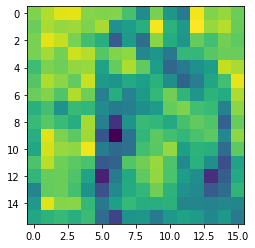

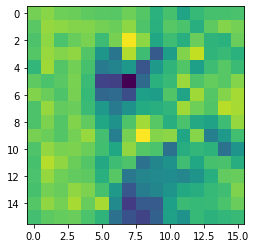

In [ ]:
for img_idx in sorted_acc_means[:9]:
  data, _ = trainset[img_idx]
  data.unsqueeze_(0)
  data = data.cuda()
  net.eval()

  output = net(data)

  act = activation['conv4'].cpu().squeeze()
  fig, axarr = plt.subplots(1,1)
  axarr.imshow(act[10])


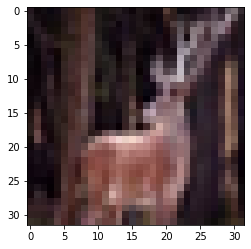

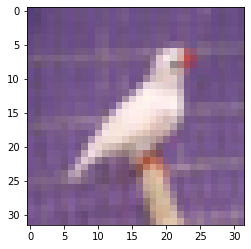

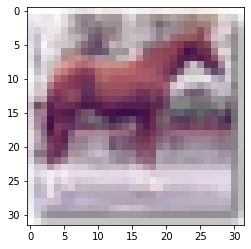

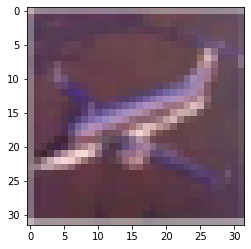

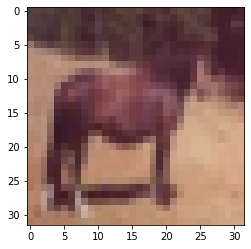

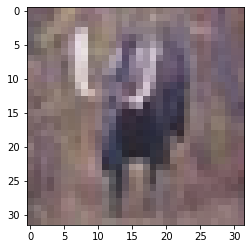

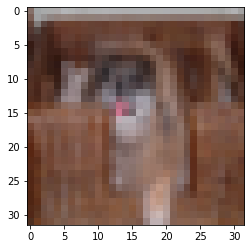

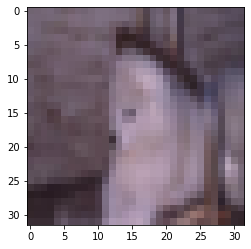

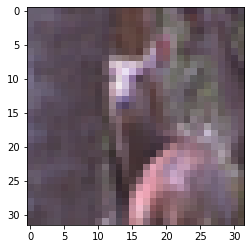

In [ ]:
# show original images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for img_idx in sorted_acc_means[:9]:
  imshow(torchvision.utils.make_grid(trainset[img_idx][0]))